# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [134]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import random

from scipy.stats import shapiro
from scipy.stats import normaltest
from statsmodels.stats.weightstats import ztest
from statsmodels.graphics.gofplots import qqplot

df = pd.read_csv('data/human_body_temperature.csv')
df.head()

,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


# 1. Is the distribution of body temperatures normal?

There a few ways in which we can evaluate if a given sample distirbution is normal: some of them rely on 
    graphical representations of the data, while others are statistical evaluations. For the sake of thoroughness,
    I will present several methods; if all methods agree, then we can have strong confidence in our conclusions
    about the data. 

## Graphical representation - histogram

(array([ 4.,  6., 15., 26., 30., 30., 15.,  1.,  2.,  1.]),
 array([ 96.3 ,  96.75,  97.2 ,  97.65,  98.1 ,  98.55,  99.  ,  99.45,
         99.9 , 100.35, 100.8 ]),
 <a list of 10 Patch objects>)

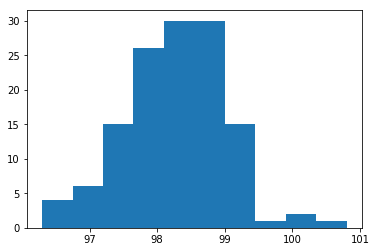

In [27]:
plt.hist(df.temperature)

Broadly speaking, the shape of the distribution seems to resemble that of a Gaussian distribution, although the 
upper end of the distribution (especially between 99-100) appears to have some missing values that would make it even more normal-like. 

## Graphical representation - Q-Q plot

Text(0.5, 1.0, 'Quantile-Quantile Plot')

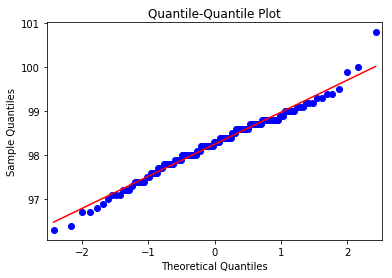

In [31]:
qqplot(df.temperature, line='s')
plt.title('Quantile-Quantile Plot')

If the data were distributed perfectly Normally, all data points would lie on the red line. As we can see,
most of the data actually does adhere closely to the line, except for data near the upper and lower quartiles, which
is similar to the situation observed from the histogram representation. These two representations of the data, however,
suggest that the data are distributed very close to Normal.

## Statistical tests
### Shapiro-Wilk

In [133]:
shap_stat, shap_p = shapiro(df.temperature)
print(shap_p)

0.233174666762352


As the p-value of the Shapiro-Wilk test is >0.05, we do not reject the null hypothesis. This suggests that the data 
does not differ significantly from a Gaussian distribution.

### D’Agostino’s K^2 Test

In [137]:
K2_stat, K2_pval = normaltest(df.temperature)
print(K2_pval)

0.2587479863488254


D'Agostino's K^2 test also suggests that the data does not differ significantly from a Gaussian distribution.

Between the graphical as well as statistical tests, we can be reasonably confident that the body temperature data
is in fact Gaussian.

# 2. Is the sample size large? Are the observations independent?

In [34]:
print("The sample size is N = {}".format(len(df.temperature)))

The sample size is N = 130


In [33]:
len(df.temperature)

130

With a sample size of N=130, the sample size is not large. However, it is 'large enough', if we apply the commonly-
used threshold of n >= 30. 

The observations in this case can be considered independent as they come from different people and there are no
known confounding variables between the observations.

# 3. Is the true population mean really 98.6 degrees F?

This question essentially requires us to test against a null hypothesis: that 98.6 degrees F does not differ 
    significantly from the data. 

To answer this question, I will first perform a bootstrap hypothesis test. This requires the use of resampling with 
replacement, which I will do 10,000 times, to generate an array of bootstrap replicate means. This should allow me 
to generate a distribution of means, from which I can then establish the 95% confidence interval and assess where
the value of '98.6' falls. If it falls outside of the 95% confidence interval, then we should reject the null
hypothesis, and conclude that the sample mean differs significantly from the population mean. 

## 3.1 Bootstrap hypothesis test

The 95% confidence interval of body temperature is: between 98.12382692307692 and 98.37692307692308 degrees Fahrenheit


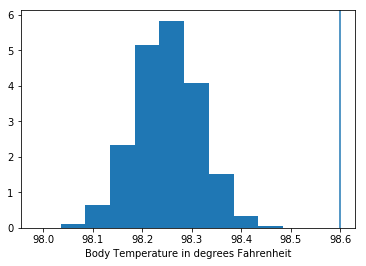

In [130]:
# Function to be able to calculate metric of interest from a bootstrap replicate
def bs_replicate_1d(data, function):
    bs_sample = np.random.choice(data, size=len(data)) #Bootstrap replicate, with same size as original sample size
    return function(bs_sample)

# Function to generate an array of bootstrap means
def bs_reps(data, function, size=1):
    """Draw bootstrap replicates"""
    # Initialize empty array
    bs_replicates = np.empty(size)
    #Generate replicates
    for i in range(size):
        bs_replicates[i] = bs_replicate_1d(data, function)
    return bs_replicates

# Histogram of results from all replicates
bs_replicates = bs_reps(df.temperature, np.mean, size=10000) #Array of means of the bootstrap replicates
plt.hist(bs_replicates, density=True)
plt.axvline(x=98.6) #Draw a vertical line at 98.6 degrees
plt.xlabel("Body Temperature in degrees Fahrenheit")

conf_int = np.percentile(bs_replicates, [2.5, 97.5])
print("The 95% confidence interval of body temperature is: between {} and {} degrees Fahrenheit".format(conf_int[0], 
                                                                                                        conf_int[1]))

In this situation, we are essentially testing against a null hypothesis, where the null hypothesis is : 
    the mean of the sample data does not differ significantly from 98.6 degrees Fahrenheit. What we find is that 
    98.6 degrees Fahrenheit actually differs significantly from the data, as it falls outside the 
    standard threshold of the 95% confidence interval of the distribution achieved through bootstrapping. Visually,
    we can see from the figure that the distribution of the sample data falls almost entirely below the 98.6 degree
    mark, which supports the conclusion.
    
As such, we reject the null hypothesis, which leads us to conclude that the data instead supports the alternate
hypothesis: that the the sample mean differs significantly from 98.6 degrees F.

## 3.2 Frequentist statistics - One sample or two sample? T or z statistic?

The first step in thinking about what frequentist test to use is to understand whether we should use a one-sample
or two-sample test. Here, we only have one sample, which we are comparing against a known value (the population mean),
and as such we should be using a one-sample test. 

The question is, is the t-statistic or z-statistic more appropriate? In this case, we have a single large sample, but 
we do not know the true population standard deviation. This ignorance of the true standard deviation suggests then
that we should be using the t-statistic instead.

For the sake of completeness, however, let's do both and see what happens. The null hypothesis is the same in both
cases: that the sample mean does not differ significantly from the population mean of 98.6 degrees F. 

In [132]:
# Perform a one sample t-test
tstat, t_pval = stats.ttest_1samp(df.temperature, 98.6)
# Trying a z test insted: how do the results differ?
zstat, z_pval = ztest(df.temperature, value=98.6)

print("The p-value from the t-test is %.3f\nThe p-value from the z-test is %.3f" %(t_pval, z_pval))

The p-value from the t-test is 0.000
The p-value from the z-test is 0.000


As we can see, both tests return the same result of a vanishingly small p-value, suggesting that the 
difference between the population mean and sample mean is extremely unlikely to be obtained by chance, and that we 
should reject the null hypothesis. In other words, **it is very likely that the sample mean is significantly different
from 98.6 degrees F**, similar to the result we obtained from bootstrapping.

# 4. Draw a small sample of size 10 from the data and repeat both frequentist tests.

As before, we do not know the population standard deviation, which suggests that we should be using the t-statistic. 
In addition, the sample size is now considered 'small' (<30), which is even more evidence that the t-statistic should
be used.

In [131]:
np.random.seed(42) # Set random seed for reproducibility
temp_10 = np.random.choice(df.temperature, size=10) #Draw sample of size 10, without replacement

tstat_10, t_pval_10 = stats.ttest_1samp(temp_10, 98.6)
zstat_10, z_pval_10 = stats.ttest_1samp(temp_10, 98.6)
print("The p-value from the t-test is %.3f\nThe p-value from the z-test is %.3f" %(t_pval_10, z_pval_10))

The p-value from the t-test is 0.013
The p-value from the z-test is 0.013


We can see that the p-values are identical across both tests. This suggests that when it comes to small sample sizes,
when we do not know the true population standard deviation, that either test may be applied.

# 5. At what temperature should we consider someone's temperature to be "abnormal"?

The answer to this question lies in the distribution of the data. The convention seems to be that any data points
that fall outside of 2 standard deviations from the mean (for normally distributed) data, can be considered 'abnormal'. 
Another way to say this is that the 95% confidence interval of the data would define what we consider 'normal'.

To answer this question, we can use a bootstrapping approach or a standard frequentist approach.

## Bootstrapping approach

In [145]:
bs_replicates = bs_reps(df.temperature, np.mean, size=10000) #Array of means of the bootstrap replicates
conf_int_temp = np.percentile(bs_replicates, [2.5, 97.5])
print("The 95% confidence interval of body temperature is: between {} and {} degrees F.".format(conf_int_temp[0], 
                                                                                                        conf_int_temp[1]))

The 95% confidence interval of body temperature is: between 98.11923076923077 and 98.37153846153845 degrees F.


Based on the 95% confidence interval derived from the bootstrapping approach, any temperature above 98.4 or below
98.1 degrees Fahrenheit can be considered abnormal.

## Frequentist approach

In [148]:
conf_int_95 = np.percentile(df.temperature, [2.5, 97.5])
print(conf_int_95)

[96.7225 99.4775]


Based on the 95% confidence interval, a body temperature below 96.7 or above 99.5 degrees F should be considered abnormal. 

# 6. Is there a significant difference between males and females in normal temperature?

With this question, we are essentially testing against the null hypothesis that there is no significant difference in 
means between male and female body temperature. To answer this question, we will need to do the following:

- Calculate the actual difference in means between males and females
- Draw 10,000 bootstrap replicates of mean male body temperatures and mean female body temperatures
- Calculate the difference between the two arrays, generating a single array of differences in means
- Compare the distribution of bootstrap differences in means to the actual difference in means to assess what proportion
    of bootstrap differences in means fall above or below the actual difference

In [120]:
#Empirical difference between males and females
mean_sex_diff = np.mean(male_temps) - np.mean(female_temps)

#Shifted arrays for males and females, because the null hypothesis is that the mean is similar
male_temps = df[df.gender=='M'].temperature
male_temps_shifted = male_temps - np.mean(male_temps) + mean_temp
female_temps = df[df.gender=='F'].temperature
female_temps_shifted = female_temps - np.mean(female_temps) + mean_temp

# Bootstrap replicates for males and females
bs_males = bs_reps(male_temps_shifted, np.mean, 10000)
bs_females = bs_reps(female_temps_shifted, np.mean, 10000)
bs_diff = bs_males - bs_females

print("The difference in body temperature between males and females is {} degrees F".format(mean_sex_diff))

The difference in body temperature between males and females is -0.289230769230727 degrees F


Text(0.5, 0, 'Difference in mean body temperature between males and females')

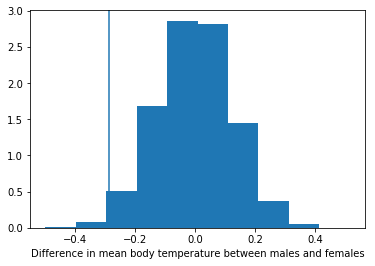

In [123]:
# Plotting the distribution of mean differences
plt.hist(bs_diff, density=True)
plt.axvline(x=-0.289230769230727) #Draw a vertical line at 98.6 degrees
plt.xlabel("Difference in mean body temperature between males and females")

From the histogram, we can see that the empirical mean difference falls to the left; as such, we should ask what 
proportion of the bootstrap mean differences are lower than the empirical mean. 

In [125]:
# Calculating the p value
pval = np.sum(bs_diff < mean_sex_diff)/10000
print("The p-value is {}".format(pval))

The p-value is 0.011


# Conclusion

In [ ]:
It appears that there is a statistically significant difference between male and female body temperature, based on the 
fact that the p-value falls below the commonly accepted threshold of 0.05. 

Although the data is normal and thus allows us to perform parametric statistical tests, I ultimately adopted a bootstrapping
approach primarily becaue I find it significantly more intuitively in terms of understanding what a p-value means. When
comparing males and females, we find that our empirical difference in means is extremely unlikely to occur under the 
null hypothesis; as such, it is fair to conclude that a statistically significant difference exists.